In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [4]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [5]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [6]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break

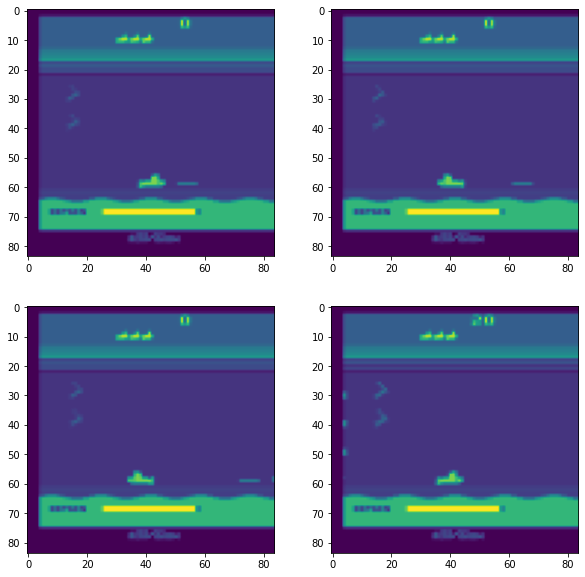

In [12]:
plt.figure(figsize=(10, 10))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs[0, :, :, k])